In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import pickle
import os

In [2]:
attrition = pd.read_csv('https://raw.githubusercontent.com/pranaymallipudi/academics/main/Final%20dataset%20Attrition.csv', error_bad_lines=False)
print(attrition.shape)

(1470, 33)


In [3]:
attrition.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Higher_Education,Date_of_Hire,Date_of_termination,Status_of_leaving,Mode_of_work,Leaves,Absenteeism,Work_accident,Source_of_Hire,Job_mode,Unnamed: 32
0,37,Yes,Travel_Rarely,Research & Development,2,Male,2,1,Laboratory Technician,3,Single,2090,6,Yes,15,3,0,7,3,0,0,0,Graduation,21-01-2021,NaN,Salary,OFFICE,4,2,No,Job Event,Contract,NaN
1,21,No,Travel_Rarely,Research & Development,15,Male,3,1,Research Scientist,4,Single,1232,1,No,14,3,0,0,6,0,0,0,Graduation,13-03-2021,NaN,Work Accident,WFH,5,2,No,Recruiter,Part Time,NaN
2,45,No,Travel_Rarely,Research & Development,6,Male,3,3,Research Director,1,Married,13245,4,Yes,14,3,0,17,3,0,0,0,Post-Graduation,23-01-2021,NaN,Dept.Head,WFH,1,3,No,Job Event,Contract,NaN
3,23,No,Travel_Rarely,Sales,2,Male,3,1,Sales Representative,1,Divorced,2322,3,No,13,3,1,3,3,0,0,0,PHD,25-04-2021,NaN,Work Accident,OFFICE,1,0,Yes,Recruiter,FullTime,NaN
4,22,No,Travel_Rarely,Research & Development,15,Female,3,1,Laboratory Technician,4,Single,2871,1,No,15,3,0,1,5,0,0,0,PHD,14-06-2021,NaN,Better Opportunity,WFH,5,2,No,Job Event,Contract,NaN


In [4]:
attrition.Status_of_leaving.isnull().sum()

0

In [5]:
attrition.Status_of_leaving.unique()

array(['Salary', 'Work Accident', 'Dept.Head', 'Better Opportunity',
       'Work Environment'], dtype=object)

**Missing value treatment**

In [6]:
#check for null values
attrition.isna().mean()*100 

Age                          0.0
Attrition                    0.0
BusinessTravel               0.0
Department                   0.0
DistanceFromHome             0.0
Gender                       0.0
JobInvolvement               0.0
JobLevel                     0.0
JobRole                      0.0
JobSatisfaction              0.0
MaritalStatus                0.0
MonthlyIncome                0.0
NumCompaniesWorked           0.0
OverTime                     0.0
PercentSalaryHike            0.0
PerformanceRating            0.0
StockOptionLevel             0.0
TotalWorkingYears            0.0
TrainingTimesLastYear        0.0
YearsAtCompany               0.0
YearsSinceLastPromotion      0.0
YearsWithCurrManager         0.0
Higher_Education             0.0
Date_of_Hire                 0.0
Date_of_termination        100.0
Status_of_leaving            0.0
Mode_of_work                 0.0
Leaves                       0.0
Absenteeism                  0.0
Work_accident                0.0
Source_of_

In [7]:
#100% of values are missing in columns date of termination and unnamed:32, so let's drop those columns
attrition.drop(columns = ['Date_of_termination','Unnamed: 32'],axis=1,inplace=True)

In [8]:
#date of hire also doesn't contribute in any way. So let's drop it
attrition.drop(["Date_of_Hire"], axis = 1,inplace = True)
attrition_eda = attrition[:]

In [9]:
object_col = []
for column in attrition.columns:
    if attrition[column].dtype == object and len(attrition[column].unique()) <= 30:
        object_col.append(column)
        #print(f"{column} : {attrition[column].unique()}")
        #print(attrition[column].value_counts())
        #print("====================================")
#object_col.remove('Attrition')

**Feature engineering**

In [10]:
#Feature engineering
#3 factors namely, PerformanceRating, JobInvolvement, JobSatisfaction were taken, 
#the sum of which was considered as Holistic Satisfaction


attrition['holistic_satisfaction'] = attrition['PerformanceRating']+attrition['JobInvolvement']+attrition['JobSatisfaction']

In [11]:
#if salary of employee is less than average salary of department, we consider him underpaid
avg_mon_inc = attrition.groupby(['Department','JobLevel'])[['MonthlyIncome']].mean()
avg_mon_inc.columns = ['avg_MonthlyIncome']
attrition = pd.merge(attrition,avg_mon_inc,on = ['Department','JobLevel'],how='left')
attrition['underpaid_flag'] = np.where(attrition['MonthlyIncome']<attrition['avg_MonthlyIncome'],0,1)

In [12]:
#EDA
cols = ['MonthlyIncome', 'OverTime', 'Age', 'DistanceFromHome', 'TotalWorkingYears', 'PercentSalaryHike', 'YearsAtCompany', 'YearsWithCurrManager', \
'NumCompaniesWorked', 'YearsSinceLastPromotion', 'holistic_satisfaction', 'Gender', ]
num = ['Age','holistic_satisfaction','YearsAtCompany','YearsWithCurrManager','YearsSinceLastPromotion',\
       'TotalWorkingYears','NumCompaniesWorked','DistanceFromHome','OverTime','PercentSalaryHike','MonthlyIncome']
cat = ['Gender','JobRole','OverTime']
print(len(num))
print(len(cat))
for col in num:
  print(f'{col} min is {attrition[col].min()}')
  print(f'{col} max is {attrition[col].max()}')
for col in cat:
  print(f'Unique values in {col} are {attrition[col].value_counts().index}')

11
3
Age min is 18
Age max is 60
holistic_satisfaction min is 5
holistic_satisfaction max is 12
YearsAtCompany min is 0
YearsAtCompany max is 40
YearsWithCurrManager min is 0
YearsWithCurrManager max is 17
YearsSinceLastPromotion min is 0
YearsSinceLastPromotion max is 15
TotalWorkingYears min is 0
TotalWorkingYears max is 40
NumCompaniesWorked min is 0
NumCompaniesWorked max is 9
DistanceFromHome min is 1
DistanceFromHome max is 29
OverTime min is No
OverTime max is Yes
PercentSalaryHike min is 11
PercentSalaryHike max is 25
MonthlyIncome min is 1009
MonthlyIncome max is 19999
Unique values in Gender are Index(['Male', 'Female'], dtype='object')
Unique values in JobRole are Index(['Sales Executive', 'Research Scientist', 'Laboratory Technician',
       'Manufacturing Director', 'Healthcare Representative', 'Manager',
       'Sales Representative', 'Research Director', 'Human Resources'],
      dtype='object')
Unique values in OverTime are Index(['No', 'Yes'], dtype='object')


In [13]:
#Category columns in the data
print(object_col)

#let's convert these to numerical values using label encoder
le = LabelEncoder()
attrition[object_col] = attrition[object_col].apply(le.fit_transform)

['Attrition', 'BusinessTravel', 'Department', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Higher_Education', 'Status_of_leaving', 'Mode_of_work', 'Work_accident', 'Source_of_Hire', 'Job_mode']


In [14]:
attrition.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Higher_Education,Status_of_leaving,Mode_of_work,Leaves,Absenteeism,Work_accident,Source_of_Hire,Job_mode,holistic_satisfaction,avg_MonthlyIncome,underpaid_flag
0,37,1,2,1,2,1,2,1,2,3,2,2090,6,1,15,3,0,7,3,0,0,0,1,2,0,4,2,0,0,0,8,2840.064516,0
1,21,0,2,1,15,1,3,1,6,4,2,1232,1,0,14,3,0,0,6,0,0,0,1,3,1,5,2,0,2,2,10,2840.064516,0
2,45,0,2,1,6,1,3,3,5,1,1,13245,4,1,14,3,0,17,3,0,0,0,3,1,1,1,3,0,0,0,7,10170.488372,1
3,23,0,2,2,2,1,3,1,8,1,0,2322,3,0,13,3,1,3,3,0,0,0,2,3,0,1,0,1,2,1,7,2506.723684,0
4,22,0,2,1,15,0,3,1,2,4,2,2871,1,0,15,3,0,1,5,0,0,0,2,0,1,5,2,0,0,0,10,2840.064516,1


**Divide the data into train and test and scale the independent variables using standard scaler**

In [26]:
#dividing the data into train and test and scaling the variables using standard scaler
X = attrition.drop('Attrition', axis=1)
y = attrition.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,
                                                    stratify=y)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
X_std = scaler.transform(X)

In [27]:
def feature_imp(df, model):
    fi = pd.DataFrame()
    fi["feature"] = df.columns
    fi["importance"] = model.feature_importances_
    return fi.sort_values(by="importance", ascending=True)

**Fit the training data to a random forest classifier**

In [28]:
rf_clf = RandomForestClassifier(n_estimators=100, bootstrap=False,
#                                      class_weight={0:stay, 1:leave}
                                    )
rf_clf.fit(X_train, y_train)
#evaluate(rf_clf, X_train, X_test, y_train, y_test)

RandomForestClassifier(bootstrap=False)

In [29]:
df = feature_imp(X, rf_clf)[:40]
df.sort_values(['importance'],ascending=True,inplace=True)
#df.to_csv('feature_imp.csv',index=False)
df.set_index('feature', inplace=True)

#df.plot(kind='barh', figsize=(10, 10))
#plt.title('Feature Importance according to Random Forest')
fig = px.bar(df, y = df.index,x = df['importance'],orientation='h',title='Feature Importance according to Random Forest')
fig.show()

**Select top 10 variables from above model and add few other variables based on domain expertise**

In [30]:
#select top 10 variables and re-calibrate the model
df.sort_values(['importance'],inplace=True,ascending=False)
df_10 = df.iloc[:10]
top10 = df_10.index.to_list()
sel_col = top10 + ['holistic_satisfaction','Gender','JobRole']
print(sel_col)
X = attrition.loc[:,sel_col]
y = attrition.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,
                                                    stratify=y)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
X_std = scaler.transform(X)


rf_clf = RandomForestClassifier(n_estimators=100, bootstrap=False,
#                                      class_weight={0:stay, 1:leave}
                                    )
rf_clf.fit(X_train, y_train)

pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(rf_clf, open('model.pkl', 'wb'))


['OverTime', 'MonthlyIncome', 'Age', 'TotalWorkingYears', 'DistanceFromHome', 'YearsAtCompany', 'PercentSalaryHike', 'NumCompaniesWorked', 'StockOptionLevel', 'YearsSinceLastPromotion', 'holistic_satisfaction', 'Gender', 'JobRole']


**Apply random forest again on top 10 + other important variables**

In [31]:
df = feature_imp(X, rf_clf)[:40]
df.sort_values(['importance'],ascending=True,inplace=True)
#df.to_csv('feature_imp.csv',index=False)
df.set_index('feature', inplace=True)

#df.plot(kind='barh', figsize=(10, 10))
#plt.title('Feature Importance according to Random Forest')
fig = px.bar(df, y = df.index,x = df['importance'],orientation='h',title='Feature Importance according to Random Forest')
fig.show()

# **Additional EDA Miscellaneous**

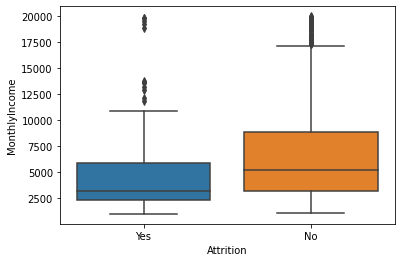

In [22]:
sns.boxplot(x = attrition_eda['Attrition'],y = attrition_eda['MonthlyIncome'])

In [32]:
temp = pd.crosstab(attrition_eda['Attrition'],attrition_eda['OverTime'])
temp

OverTime,No,Yes
Attrition,,
No,944,289
Yes,110,127


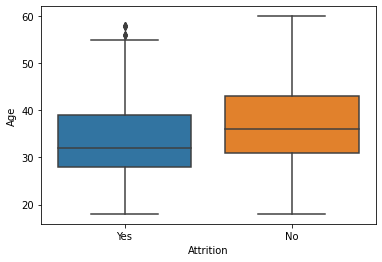

In [33]:
sns.boxplot(x = attrition_eda['Attrition'],y = attrition_eda['Age'])

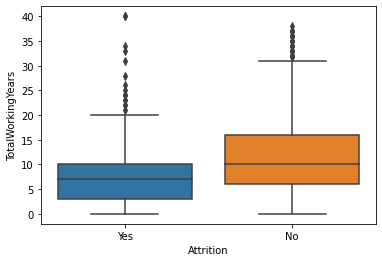

In [34]:
sns.boxplot(x = attrition_eda['Attrition'],y = attrition_eda['TotalWorkingYears'])

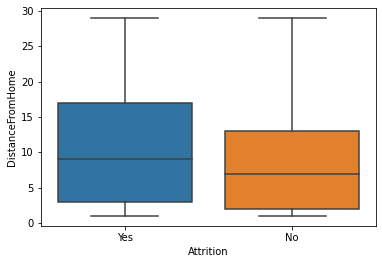

In [35]:
sns.boxplot(x = attrition_eda['Attrition'],y = attrition_eda['DistanceFromHome'])

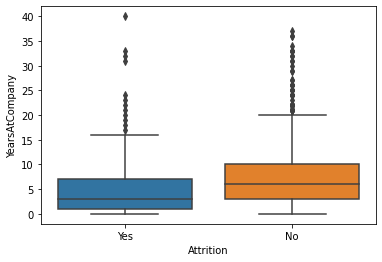

In [36]:
sns.boxplot(x = attrition_eda['Attrition'],y = attrition_eda['YearsAtCompany'])

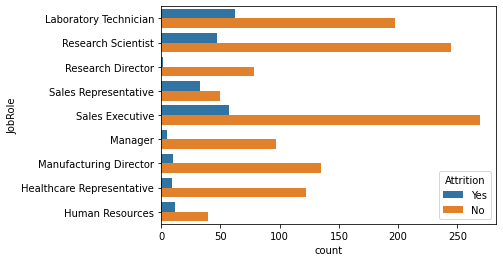

In [37]:
sns.countplot(y = attrition_eda['JobRole'],hue = attrition_eda['Attrition'])
plt.show()

In [38]:
attrition_eda['Attr_Num'] = attrition_eda['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

In [39]:
attrition_eda.groupby('JobRole')['Attr_Num'].mean()*100

JobRole
Healthcare Representative     6.870229
Human Resources              23.076923
Laboratory Technician        23.938224
Manager                       4.901961
Manufacturing Director        6.896552
Research Director             2.500000
Research Scientist           16.095890
Sales Executive              17.484663
Sales Representative         39.759036
Name: Attr_Num, dtype: float64

Sales Representative Role has the highest attrition rate

In [40]:
# Categorical variables to consider
#['Attrition', 'BusinessTravel', 'Department', 'Gender', 'JobRole', 
#'MaritalStatus', 'OverTime', 'Higher_Education', 'Status_of_leaving', 
#'Mode_of_work', 'Work_accident', 'Source_of_Hire', 'Job_mode']
temp = pd.crosstab(attrition_eda['Attrition'],attrition_eda['Source_of_Hire'])
temp

Source_of_Hire,Job Event,Job Portal,Recruiter,Walk-in
Attrition,,,,
No,315,288,327,303
Yes,57,59,63,58


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



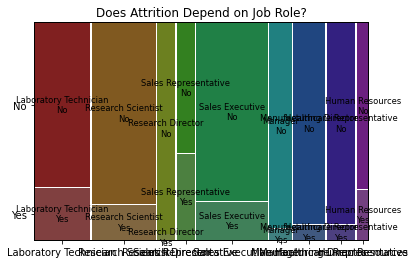

<Figure size 1440x1440 with 0 Axes>

In [41]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(attrition_eda, ['JobRole', 'Attrition'], title = 'Does Attrition Depend on Job Role?')
plt.figure(figsize = (20,20))
plt.show()

In [42]:
import plotly.express as px
fig = px.bar(attrition_eda, y = attrition_eda['Leaves'],x = attrition_eda['Attrition'], text=attrition_eda['Leaves'] )
fig.show()